In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import os
import sys
from typing import Tuple

from dataclasses import dataclass

if '' in sys.path:
    sys.path.remove('')

module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

import networkx as nx

from graphPlot import drawGraph, setCanvas
from const import *

setCanvas()

## Harmonic Net (CVPR 2017*)

| - | Input $f(x)$ | High-level $f_+(y)$, $f_{++}(z)$, ... | Augmentation $A_{ug}$, $U_{ga}$, ...
| --- |---|---|---
| domain | $R^2$ | $O(2)$ | $O(2) \cong R^2 \times SO(2)$ (translation, arbitrary rotation)

---

- Size of the filter bank become intolerably big, can't take it any more

- First algorithm to use **spectral decomposition as a weight compressor**

| <img src="assets/hnet.gif"> |
| :---: |

---

[*] D. E. Worrall, S. J. Garbin, D. Turmukhambetov, and G. J. Brostow, “Harmonic Networks: Deep Translation and Rotation Equivariance” CVPR 2017, vol. 2017–Jan, pp. 7168–7177.

## Going Spectral

- function is like infinite-dimension vector

- Spectral decomposition for functions is like eigen-decomposition for vectors

---

*orthonormal basis*: given a function domain $X \longrightarrow C$, there may exist a (likely infinite) series of bases ${u_1, u_2, ...}$ that are both:

- **complete**: linear combination can approximate arbitrary function on the domain
    
$$
f(.) = \sum_{\forall m} \phi_m u_m(.) = \Big[ \phi_1, \phi_2, ... \Big]
\begin{bmatrix}
    u_1(.) \\
    u_2(.) \\
    ...
\end{bmatrix}
$$

- ... and **orthonormal**: have unit norms and orthogonal to each other

$$
<u_m(.), u_n(.)> = I_{mn} \text{  (Kronecker delta)}
$$

- ... which implies:

$$
\phi_m = \widehat{f}(m) = <f(.), u_m(.)> \text{  (GFT)}
$$

## Going Spectral - What's the point?

It makes a few things easier:

- Convolution theorem still works in most cases! a.k.a. **G-conv theorem**

$$
\widehat{f_+}(m) = < \widehat{A_{ug}}(m) \circ \widehat{f}(m), \widehat{w_0}(m) >_m
$$

(This makes dot product and G-conv much faster)

- Most G-ConvNet features are smooth on all dimensions

(This means low-frequency coefficients can compress high-dimension filter banks)

## *G-conv Theorem - Proof*

\begin{align}
& & f_+(y) &= <A_{ug} \circ f(x), w_0(x)>_x \\
& & &= \sum_m \sum_n \widehat{A_{ug} \circ f}(m) \widehat{w_0}(j) <u_m(.), u_n(.)> \\
&\text{(orthonormal)} & &= \sum_m \widehat{A_{ug} \circ f}(m) \widehat{w_0}(m) \\
&\text{(GFT)} & &= \sum_m < A_{ug} \circ f(x), u_m(x) >_x \cdot < w_0(x), u_m(x) >_x
\end{align}

---

[*] More rigorous proof for $SO(3)$ case: T. S. Cohen, M. Geiger, J. Koehler, and M. Welling, “Spherical CNNs,” no. 3, pp. 1–15, 2018.

## *G-conv Theorem - Proof*

If luckily $A_{ug}$ is linear:

\begin{align}
&\text{(bijectory)} & \widehat{f_+}(n) &= \sum_m \Big< < \bbox[yellow]{A_{ug}(y)} \circ f(x), u_m(x) >_x \Big| u_n(y) \Big>_y \cdot < w_0(x), u_m(x) >_x \\
&\text{(linear)} & &= \sum_m < u_n(y), A_{ug}(y)>_y \circ < f(x), u_m(x) >_x \cdot < w_0(x), u_m(x) >_x \\
& & &= < \widehat{A_{ug}}(n) \circ \widehat{f}(m), \widehat{w_0}(m) >_m\\
& \text{(IFF $A_{ug}$ is distance-preserving)} & &= <\widehat{f}(m), \widehat{A_{ug}^{-1}}(n) \circ \widehat{w_0}(m) >_m 
\end{align}

## Harmonic Net (CVPR 2017*)

| - | Input $f(x)$ | High-level $f_+(y)$, $f_{++}(z)$, ... | Augmentation $A_{ug}$, $U_{ga}$, ...
| --- |---|---|---
| domain | $R^2$ | $O(2)$ | $O(2) \cong R^2 \times SO(2)$ (translation, arbitrary rotation)

---

- $u_m(x) \longleftarrow e^{m x}$ (2D Fourier series, x is a complex number)
- GFT $\longleftarrow$ FFT (with Gaussian resampling)
- number of coefficients $\longleftarrow 2$: $m \in {0, 1}$

---

[*] D. E. Worrall, S. J. Garbin, D. Turmukhambetov, and G. J. Brostow, “Harmonic Networks: Deep Translation and Rotation Equivariance” CVPR 2017, vol. 2017–Jan, pp. 7168–7177.

## Harmonic Net (CVPR 2017*)

---

Orthonormal bases (without radial):

<img src="assets/hnet-bases.png" style="height: 350px;">

---

[*] D. E. Worrall, S. J. Garbin, D. Turmukhambetov, and G. J. Brostow, “Harmonic Networks: Deep Translation and Rotation Equivariance” CVPR 2017, vol. 2017–Jan, pp. 7168–7177.

## Harmonic Net (CVPR 2017*)

---

Orthonormal bases (with radial):

<img src="assets/fourier-full.png" style="height: 350px;">

---

[*] Image courtesy: C. E. Coleman-Smith, H. Petersen, and R. L. Wolpert, “Classification of initial state granularity via 2d Fourier Expansion” Apr. 2012.

## Harmonic Net (CVPR 2017*)

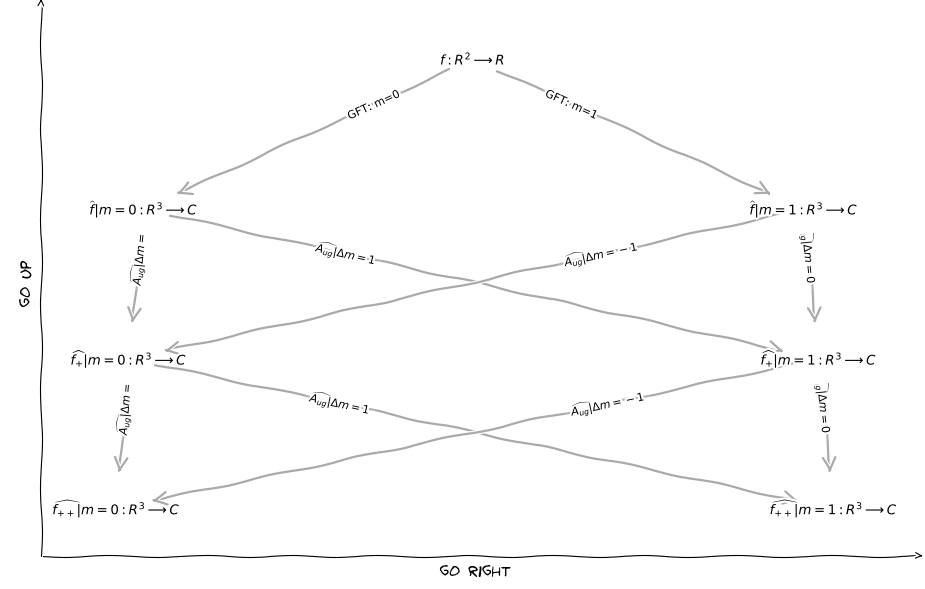

In [49]:
g = nx.DiGraph(directed=True)

tail = "$f: R^2 \longrightarrow R$"

angles = [0, 1]


def repr(r: int) -> str:
    if r > 0:
        return f"{str(r)}"
    else:
        return f"{str(r)}"


sub = ""
subPlus = ""


def getNode(sub, i):
    return f"$\widehat{{f_{{{sub}}}}} | m={repr(i)}: R^3 \longrightarrow C$"


for i in angles:
    node = getNode(sub, i)
    g.add_edge(tail, node, text=f"GFT: m=${repr(i)}$")

for epoch in range(1, 3):
    subPlus = f"{sub}+"
    for i in angles:
        for j in angles:
            prev = getNode(sub, i)
            node = getNode(subPlus, j)
            g.add_edge(prev, node, text=f"$\widehat{{A_{{ug}}}} | \Delta m={repr(j - i)}$")
    sub = subPlus

drawGraph(g, font='humor sans', label_pos=0.7)

plt.show()

## Spherical CNNs (ICLR 2018* best paper)

You can use many cameras for situation awareness

<img src="assets/tesla-cameras.png" style="height: 400px;">

---

[*] Image Courtesy: https://www.tesla.com/en_CA/autopilot

## Spherical CNNs (ICLR 2018* best paper)

... Or you can use few fisheye camera(s)

<img src="assets/drone-fisheye.png" style="height: 400px;">

---

[*] Image courtesy: DJI-X https://www.halfchrome.com/dji-360-drone/

## Spherical CNNs (ICLR 2018* best paper)

Instead ...

<img src="assets/beholder.jpg" style="height: 400px;">

---

[*] Image Courtesy: Skydio R1 https://www.skydio.com/technology/


## Spherical CNNs (ICLR 2018* best paper)

Instead ...

<img src="assets/skydioR1.jpg">

---

[*] Image Courtesy: Skydio R1 https://www.skydio.com/technology/


## Spherical CNNs (ICLR 2018* best paper)

| - | Input $f(x)$ | High-level $f_+(y)$, $f_{++}(z)$, ... | Augmentation $A_{ug}$, $U_{ga}$, ...
| --- |---|---|---
| domain | $S^2$ | $SO(3)$ | $SO(3) \cong SU(2)$ (3d rotation)

---

- $u_m(x) \longleftarrow D_m(x)$ (Wigner-D function, $x$ is an Euler-angle tuple or quaternion)
    - collapses to spherical harmonics on the first layer
- GFT $\longleftarrow$ SO(3) FFT
- number of coefficients $\leq 25$: $l \in [0, 4]$ (increasing beyond that contributes little to accuracy)

---

[*] T. S. Cohen, M. Geiger, J. Koehler, and M. Welling, “Spherical CNNs,” no. 3, pp. 1–15, 2018.

## Spherical CNNs (ICLR 2018* best paper)

| - | Input $f(x)$ | High-level $f_+(y)$, $f_{++}(z)$, ... | Augmentation $A_{ug}$, $U_{ga}$, ...
| --- |---|---|---
| domain | $S^2$ | $SO(3)$ | $SO(3) \cong SU(2)$ (3d rotation)

---

<img src="assets/sh_basis.png" style="height: 400px;"> 

---

[*] T. S. Cohen, M. Geiger, J. Koehler, and M. Welling, “Spherical CNNs,” no. 3, pp. 1–15, 2018.

## Spherical CNNs (ICLR 2018* best paper)

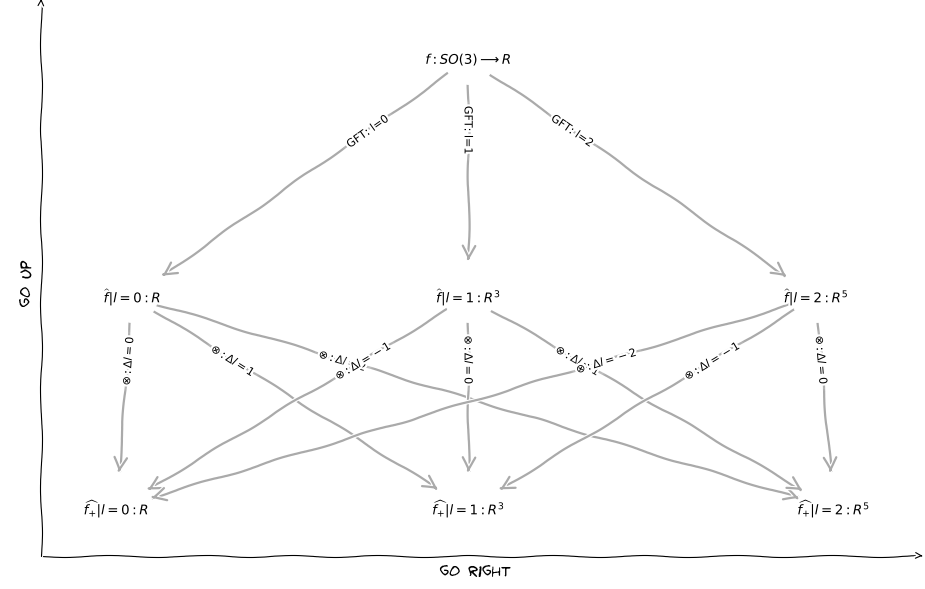

In [50]:
g = nx.DiGraph(directed=True)

tail = "$f: SO(3) \longrightarrow R$"

angles = [0, 1, 2]


def repr(r: int) -> str:
    if r > 0:
        return f"{str(r)}"
    else:
        return f"{str(r)}"


sub = ""
subPlus = ""


def getExp(i):
    j = 2*i + 1
    if j == 1:
        return ""
    else:
        return f"^{str(j)}"

def getNode(sub, i):
    return f"$\widehat{{f_{{{sub}}}}} | l={repr(i)}: R{getExp(i)}$"


for i in angles:
    node = getNode(sub, i)
    g.add_edge(tail, node, text=f"GFT: l=${repr(i)}$")

for epoch in range(1, 2):
    subPlus = f"{sub}+"
    for i in angles:
        for j in angles:
            prev = getNode(sub, i)
            node = getNode(subPlus, j)
            g.add_edge(prev, node, text=f"$\otimes: \Delta l={repr(j - i)}$")
    sub = subPlus

drawGraph(g, font='humor sans', label_pos=0.7)

plt.show()

## Tensor Field Network (Not Peer Reviewed!)

| - | Input $f(x)$ | High-level $f_+(y)$, $f_{++}(z)$, ... | Augmentation $A_{ug}$, $U_{ga}$, ...
| --- |---|---|---
| domain | $R^3$ | $O(3)$ | $O(3) \cong R^3 x SO(3)$ (3d translation & rotation)

---

- $u_m(x) \longleftarrow D_m(x)$ (Wigner-D function, $x$ is an Euler-angle tuple or quaternion)
    - collapses to spherical harmonics on the first layer
- GFT $\longleftarrow$ SO(3) FFT
- number of coefficients $\longleftarrow 4$: $l \in {0, 1}$
- C-G transformation is used to accelerate G-conv in frequency space
    - which was not needed in Spherical CNNs due to lack of radial component



## Tensor Field Network (Not Peer Reviewed!)

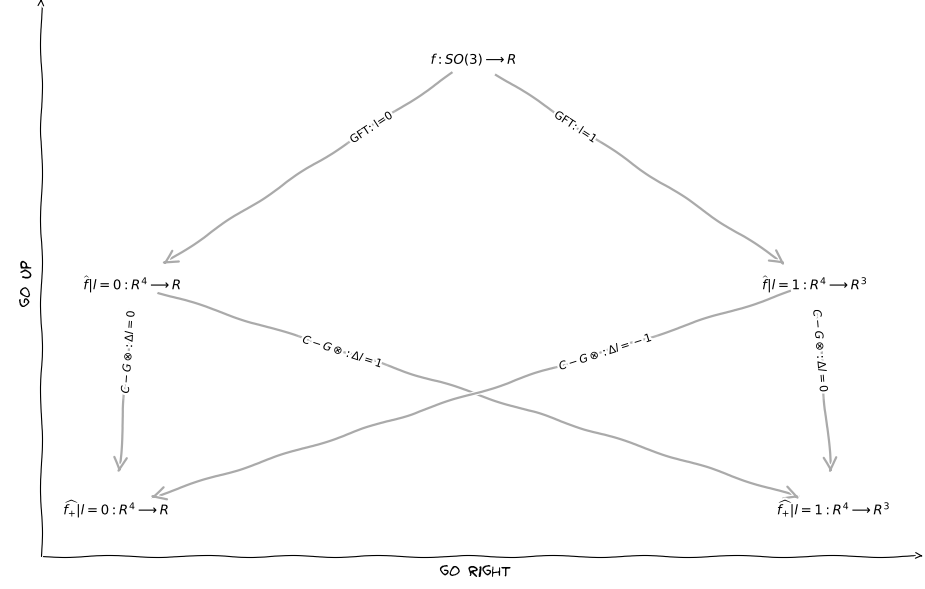

In [51]:
g = nx.DiGraph(directed=True)

tail = "$f: SO(3) \longrightarrow R$"

angles = [0, 1]


def repr(r: int) -> str:
    if r > 0:
        return f"{str(r)}"
    else:
        return f"{str(r)}"


sub = ""
subPlus = ""


def getExp(i):
    j = 2*i + 1
    if j == 1:
        return ""
    else:
        return f"^{str(j)}"

def getNode(sub, i):
    return f"$\widehat{{f_{{{sub}}}}} | l={repr(i)}: R^4 \longrightarrow R{getExp(i)}$"


for i in angles:
    node = getNode(sub, i)
    g.add_edge(tail, node, text=f"GFT: l=${repr(i)}$")

for epoch in range(1, 2):
    subPlus = f"{sub}+"
    for i in angles:
        for j in angles:
            prev = getNode(sub, i)
            node = getNode(subPlus, j)
            g.add_edge(prev, node, text=f"$C-G \otimes: \Delta l={repr(j - i)}$")
    sub = subPlus

drawGraph(g, font='humor sans', label_pos=0.7)

plt.show()
